<a href="https://colab.research.google.com/github/msalunina/aidl-2026-3d-semantic-segmentation/blob/eva/Eva_pointnet_explained_visually_ModelNet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing PointNet implementation (ModelNet10 dataset)

[PointNet](https://arxiv.org/pdf/1612.00593.pdf) is a deep net architecture that **consumes point clouds** (set of points) for applications ranging from **object classification**, part **segmentation**, to scene **semantic parsing**. It was implemented in 2017 and was the first architecure that directly took point clouds as input for 3D recognition tasks.

Point cloud data is a 3D representation of an object or scene, typically collected from either a lidar or radar sensor. These sensors emit pulses of light or radio waves and then measure the time it takes for them to return to the sensor. This information can be used to create a 3D model of the object or scene.

We are going to implement the classification model of pointnet and visualize its transformations. This will help us to better understand how the model works.

### Contents

- **Dataset**
    - Transform 3D meshes ModelNet10 dataset into 3D point cloud dataset
- **Architecture**
    - Properties of Point Sets in Rn
    - Visualizing T-Net transformation
    - Does changing the order of points affect the prediction?
    - Visualizing learned critical points
- **Take aways**

## ModelNet10 Dataset

For the sake of clarity and to stay close to the original PointNet paper, we use the **ModelNet10** dataset. ModelNet10 contains **10 categories of 3D objects** (e.g., chair, table, sofa, bathtub), represented as **CAD models**.

ModelNet10 does **not** provide point clouds directly. Instead, each object is stored as a **polygonal mesh** in the `.off` file format, consisting of vertices and triangular faces.


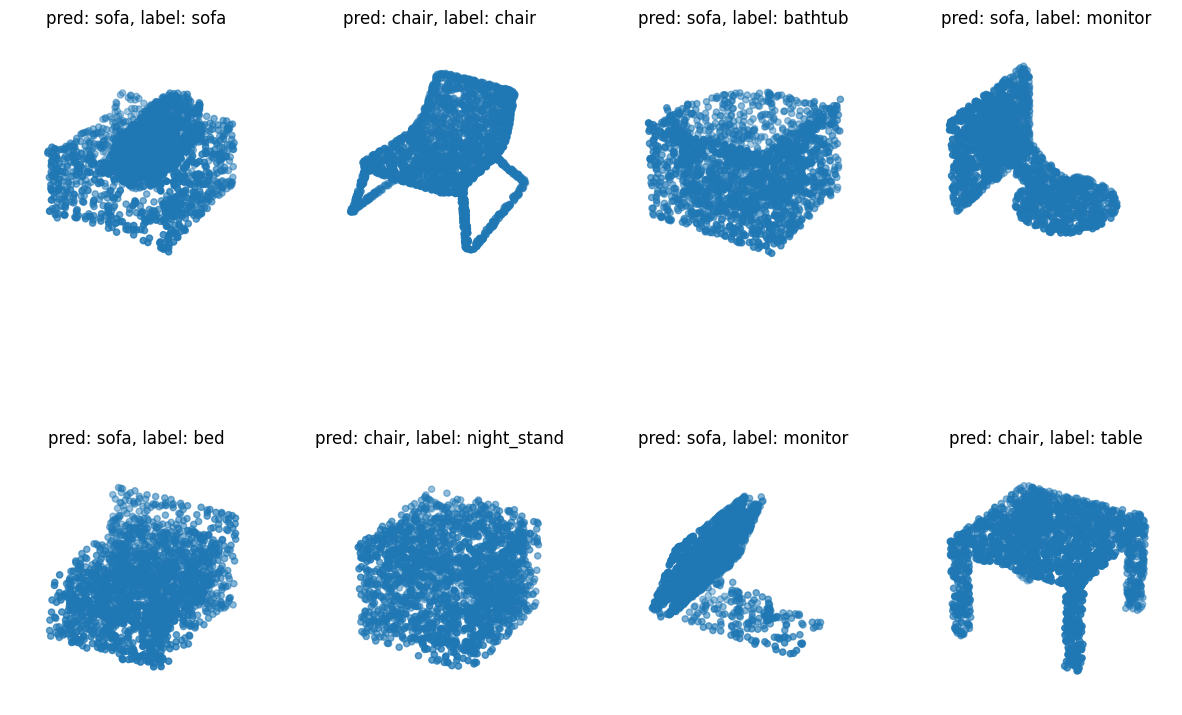

ModelNet10 objects are meshes, but **PointNet operates on point clouds**.  
Therefore, before training the model, we must **convert each mesh into a point cloud**.



We can load the dataset directly from disk. ModelNet10 samples are stored as **3D CAD meshes** in the `.off` file format, consisting of vertices and triangular faces.

Since PointNet operates on **point clouds**, we want to transform each mesh into a set of 3D points. To do so, we sample points **uniformly from the surface of the mesh**. Each sampled point is represented by its spatial coordinates \((x, y, z)\).

We define the function `transform_mesh2pc`, which loads a mesh file, samples a fixed number of points from its surface, and returns the resulting point cloud as a floating-point array.


In [1]:
!pip install trimesh

import numpy as np
import trimesh

def transform_mesh2pc(off_path, n_points=1024):
    """
    Convert a ModelNet10 mesh (.off file) into a point cloud by
    sampling points uniformly from the mesh surface.
    """
    mesh = trimesh.load(off_path, force="mesh")

    # Some OFF files load as a Scene; merge geometries if needed
    if not isinstance(mesh, trimesh.Trimesh):
        mesh = trimesh.util.concatenate(
            [g for g in mesh.geometry.values()]
        )

    # Sample points from the surface
    points, _ = trimesh.sample.sample_surface(mesh, n_points)

    return points.astype(np.float32)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.4/740.4 kB 46.3 MB/s eta 0:00:00


Once we have converted meshes into point clouds, we need **all point clouds to have the same number of points** so that they can be used as input to PointNet.

Unlike the MNIST case, where the number of points depends on how many pixels exceed a threshold, ModelNet10 objects are **continuous surfaces**. This means we can explicitly control the number of points by choosing how many points to sample from each mesh.

The original PointNet paper uses **1024 or 2048 points per object**. Before fixing this number, we inspect the distribution of point counts obtained from surface sampling to motivate our choice.


In [2]:
import urllib.request
import zipfile
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

MODELNET10_URL = "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"
ZIP_PATH = DATA_DIR / "ModelNet10.zip"
EXTRACT_DIR = DATA_DIR / "ModelNet10"

def download(url: str, out_path: Path):
    if out_path.exists():
        print(f"Found existing: {out_path}")
        return
    print(f"Downloading: {url}")
    urllib.request.urlretrieve(url, out_path)
    print(f"Saved to: {out_path}")

def extract(zip_path: Path, out_dir: Path):
    if out_dir.exists() and any(out_dir.iterdir()):
        print(f"Found extracted dataset at: {out_dir}")
        return
    print(f"Extracting: {zip_path} -> {out_dir}")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(out_dir)
    print("Done.")

download(MODELNET10_URL, ZIP_PATH)
extract(ZIP_PATH, EXTRACT_DIR)

# The archive extracts into a nested ModelNet10 folder for most distributions.
# Normalize the path so EXTRACT_DIR points to the folder containing class subfolders.
nested = EXTRACT_DIR / "ModelNet10"
if nested.exists():
    EXTRACT_DIR = nested

print("Dataset root:", EXTRACT_DIR)
print("Classes:", sorted([p.name for p in EXTRACT_DIR.iterdir() if p.is_dir()])[:20])

Downloading: http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Saved to: data/ModelNet10.zip
Extracting: data/ModelNet10.zip -> data/ModelNet10
Done.
Dataset root: data/ModelNet10/ModelNet10
Classes: ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']


Number of meshes: 4899


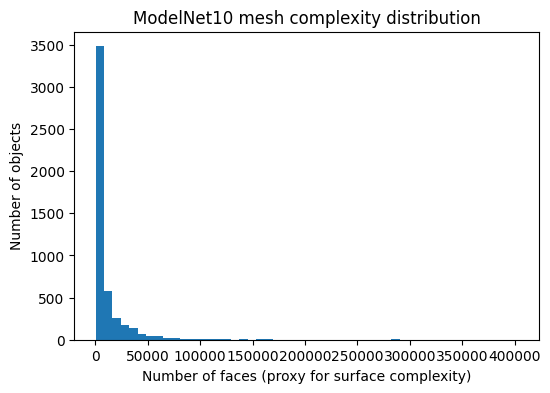

In [3]:
import matplotlib.pyplot as plt
from pathlib import Path
import trimesh

# Path to extracted ModelNet10 dataset (matches earlier cells)
# EXTRACT_DIR = Path("data/ModelNet10") # Corrected path - Removed as EXTRACT_DIR is already correctly set globally

# Collect all OFF files, excluding __MACOSX metadata files
all_off_files = [f for f in EXTRACT_DIR.rglob("*.off") if "__MACOSX" not in str(f)]
print("Number of meshes:", len(all_off_files))

assert len(all_off_files) > 0, "No .off files found — check dataset path."

# Use number of faces as a proxy for surface complexity
mesh_complexity = []

for off_path in all_off_files:
    mesh = trimesh.load(off_path, force="mesh")
    # Some OFF files load as a Scene; merge geometries if needed
    if not isinstance(mesh, trimesh.Trimesh):
        mesh = trimesh.util.concatenate(
            [g for g in mesh.geometry.values()]
        )

    mesh_complexity.append(len(mesh.faces))

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(mesh_complexity, bins=50)
plt.xlabel("Number of faces (proxy for surface complexity)")
plt.ylabel("Number of objects")
plt.title("ModelNet10 mesh complexity distribution")
plt.show()

From the distribution above, we see that ModelNet10 objects vary significantly
in surface complexity. However, PointNet requires a **fixed-size input**.

Instead of truncating or padding variable-length point clouds, we take advantage
of surface sampling and sample a **fixed number of points per object**.
In the remainder of this notebook, we use **1024 points per object**, which is
consistent with the original PointNet architecture.


### Dataset

Let's implement the data processing in a Dataset class.
## Dataset

We now implement the data processing logic using a custom `Dataset` class.

Each ModelNet10 sample is stored as a **3D mesh** (`.off` file). For every access,
we convert the mesh into a **point cloud** by sampling a fixed number of points
from its surface. This ensures that all samples have the same shape and can be
used as input to PointNet.

During training, we also apply simple data augmentation such as random rotation
and jittering to improve generalization.


In [4]:
import torch
from torch.utils.data import Dataset
import numpy as np
import trimesh
from pathlib import Path

class ModelNet10Dataset(Dataset):
    """
    ModelNet10 point cloud dataset.
    Each sample is generated by sampling points from a mesh surface.
    """

    NUM_CLASSES = 10
    POINT_DIMENSION = 3

    def __init__(self, root_dir, split="train", num_points=1024, augment=False):
        """
        Args:
            root_dir (str or Path): Path to ModelNet10 root directory
            split (str): 'train' or 'test'
            num_points (int): Number of points per object
            augment (bool): Whether to apply data augmentation
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.num_points = num_points
        self.augment = augment

        self.classes = sorted(
            [p.name for p in self.root_dir.iterdir() if p.is_dir()]
        )
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.samples = []
        for cls in self.classes:
            cls_dir = self.root_dir / cls / split
            for off_path in cls_dir.glob("*.off"):
                self.samples.append((off_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def _sample_point_cloud(self, off_path):
        mesh = trimesh.load(off_path, force="mesh")
        if not isinstance(mesh, trimesh.Trimesh):
            mesh = trimesh.util.concatenate(
                [g for g in mesh.geometry.values()]
            )

        points, _ = trimesh.sample.sample_surface(mesh, self.num_points)

        # Normalize to unit sphere
        points = points - points.mean(axis=0)
        scale = np.linalg.norm(points, axis=1).max()
        points = points / (scale + 1e-9)

        return points.astype(np.float32)

    def _augment(self, points):
        # Random rotation around Z axis
        theta = np.random.uniform(0, 2 * np.pi)
        rot = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta),  np.cos(theta), 0],
            [0,              0,             1],
        ])
        points = points @ rot.T

        # Jitter
        points += np.random.normal(0, 0.01, size=points.shape)

        return points

    def __getitem__(self, idx):
        off_path, label = self.samples[idx]
        points = self._sample_point_cloud(off_path)

        if self.augment:
            points = self._augment(points)

        points = torch.tensor(points, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return points, label


### Hyperparameters
## Hyperparameters

We now define the hyperparameters used for training PointNet on ModelNet10.
These values closely follow the original PointNet paper and common practice
in point cloud classification tasks.


In [5]:
# Dataset / data loader
dataset_name = "ModelNet10"
num_points = 1024
batch_size = 32
num_workers = 0

# Optimization
learning_rate = 1e-3
num_epochs = 50

# Model
num_classes = 10
input_dim = 3


### Dataloaders
## Dataloaders

We create PyTorch `DataLoader`s for training, validation, and testing.

ModelNet10 already provides separate `train/` and `test/` folders.  
We will use the official `test/` split as our test set, and we will create a
validation set by splitting the training set.


In [6]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from pathlib import Path

# --------------------------------------------------
# Robustly locate ModelNet10 root directory
# --------------------------------------------------
candidates = [
    Path("data/ModelNet10/ModelNet10"),
    Path("data/ModelNet10"),
    Path("ModelNet10/ModelNet10"),
    Path("ModelNet10"),
]

# Also include EXTRACT_DIR if defined earlier
if "EXTRACT_DIR" in globals():
    candidates.insert(0, Path(EXTRACT_DIR))

modelnet_root = None
for c in candidates:
    if c.exists() and c.is_dir():
        for d in c.iterdir():
            if d.is_dir() and (d / "train").exists():
                modelnet_root = c
                break
    if modelnet_root is not None:
        break

assert modelnet_root is not None, (
    "Could not locate ModelNet10 dataset root. "
    "Make sure ModelNet10 has been downloaded and extracted."
)

print("Using ModelNet10 root:", modelnet_root)

# --------------------------------------------------
# IMPORTANT: safest setting for notebooks
# --------------------------------------------------
num_workers = 0   # prevents DataLoader + trimesh deadlocks

# --------------------------------------------------
# Build datasets
# --------------------------------------------------
full_train_dataset = ModelNet10Dataset(
    root_dir=modelnet_root,
    split="train",
    num_points=num_points,
    augment=True
)

test_dataset = ModelNet10Dataset(
    root_dir=modelnet_root,
    split="test",
    num_points=num_points,
    augment=False
)

# --------------------------------------------------
# Train / validation split
# --------------------------------------------------
val_fraction = 0.1
n_total = len(full_train_dataset)
n_val = int(val_fraction * n_total)
n_train = n_total - n_val

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(1)
)

# --------------------------------------------------
# DataLoaders (single-process = stable)
# --------------------------------------------------
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

print(
    f"Train: {len(train_dataset)}, "
    f"Val: {len(val_dataset)}, "
    f"Test: {len(test_dataset)}"
)


Using ModelNet10 root: data/ModelNet10/ModelNet10
Train: 3592, Val: 399, Test: 908


### Visualization

## Visualization

Before training PointNet, we visualize a few point clouds from the dataset to
ensure that the preprocessing pipeline is working correctly.

Each sample is an unordered set of 3D points sampled from a ModelNet10 mesh.


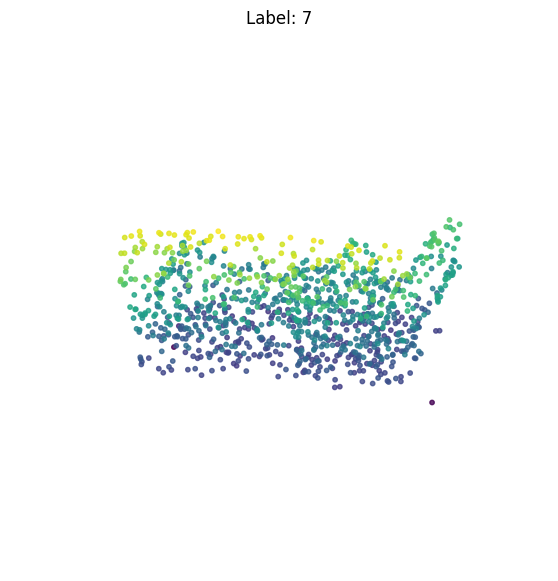

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Pick one sample from the training set
points, label = train_dataset[0]

# Convert to numpy for plotting
points = points.numpy()

# Plot point cloud
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c=points[:, 2],          # color by z for depth perception
    s=10,
    cmap="viridis",
    alpha=0.8
)

ax.set_title(f"Label: {label}")
ax.set_axis_off()
plt.show()


### Animated visualization

To better understand the 3D structure of point clouds, we visualize a single
ModelNet10 object while rotating the camera around it. This helps build
intuition about the geometry represented by an unordered set of points.


In [8]:
import plotly.graph_objects as go
import numpy as np

# Pick one sample from the training dataset
points, label = train_dataset[0]
points = points.numpy()

x, y, z = points[:, 0], points[:, 1], points[:, 2]

# Initial scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=dict(
                size=3,
                color=z,          # color by height
                colorscale="Viridis",
                opacity=0.8
            )
        )
    ]
)

# Create camera rotation frames
frames = []
angles = np.linspace(0, 2 * np.pi, 60)

for theta in angles:
    camera = dict(
        eye=dict(
            x=1.5 * np.cos(theta),
            y=1.5 * np.sin(theta),
            z=0.8
        )
    )
    frames.append(go.Frame(layout=dict(scene_camera=camera)))

fig.frames = frames

# Layout with play button
fig.update_layout(
    title=f"360° rotation of a ModelNet10 point cloud (label={label})",
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode="data"
    ),
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None,
                        dict(
                            frame=dict(duration=50, redraw=True),
                            transition=dict(duration=0),
                            fromcurrent=True,
                            mode="immediate"
                        )
                    ]
                )
            ],
            x=0.1,
            y=0
        )
    ]
)

fig.show()


## Architecture
PointNet is composed of a classification network and a segmentation network. The classification network takes n points (x, y, z) as input, applies input and feature transformations by using T-Net, and then aggregates point features by max pooling. The output is classification scores for k classes. The segmentation network is an extension to the classification net. It concatenates global and local features and outputs per point scores.

The architecture of pointNet is inspired by the properties of point sets, they are key to some of the design choices… Let's check them!

### Properties of Point Sets
- **Unordered**. Unlike pixel arrays in images, point cloud is a set of points without specific order.
    - <u>Requirement</u>: The model needs to be invariant to permutations of points
    - <u>Solution</u>: **Use max pooling** layer as a symmetric function to aggregate information from all the points. Max pooling, like * and +, are symmetric functions because the order of the inputs does not alter the result.
<br>
<br>
- **Interaction among points**. The points are from a space with a distance metric. It means that points are not isolated, and neighboring points form a meaningful subset.
    - <u>Requirement</u>: The model needs to be able to capture local structures from nearby points.
    - <u>Solution</u>: **Combine local and global information**.
<br>
<br>    
- **Invariance under transformations**. The learned representation of the point set should be invariant to certain transformations.
    - <u>Requirement</u>: Rotating and translating points all together should not modify the global point cloud category nor the segmentation of the points.
    - <u>Solution</u>: Use a **spatial transformer network** that attempts to canonicalize the data before the PointNet processes them. **T-Net** is used to align both input points and point features.


## PointNet

PointNet is composed of a **classification** network and a **segmentation network**. The classification network takes n points (x,y,z) as input, applies **input and feature transformations** by using **T-Net**, and then aggregates point features by **max pooling**. The **output is classification scores** for k classes.
The segmentation network is an extension to the classification net. It concatenates global and local features and outputs per point scores.

### T-Net

T-Net **aligns all input set to a canonical space** before feature extraction. It is used to **predict an affine transformation matrix** of 3x3 to be applied to the coordinate of input points (x,y,z).

This idea can be further extended to the alignment of feature space, as well.
You can see that the second T-Net predicts a feature transformation matrix (64x64) to align features from different input point clouds.


In [9]:
# PointNet (ModelNet10-ready): input/feature T-Nets + maxpool global feature
import torch
import torch.nn as nn
import torch.nn.functional as F

class TNet(nn.Module):
    """
    T-Net from the PointNet paper.
    Predicts a k x k transformation matrix.
    Input shape:  (B, N, k)  or (B, k, N) depending on where it's called
    We will call it with (B, N, k).
    """
    def __init__(self, k: int):
        super().__init__()
        self.k = k

        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)

        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        # Initialize fc3 weights/bias close to identity (common trick)
        nn.init.constant_(self.fc3.weight, 0.0)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, N, k)
        returns: (B, k, k)
        """
        B, N, k = x.shape
        assert k == self.k, f"Expected k={self.k}, got {k}"

        x = x.transpose(2, 1)  # (B, k, N)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))  # (B, 1024, N)

        x = torch.max(x, dim=2).values      # (B, 1024)

        x = F.relu(self.bn4(self.fc1(x)))   # (B, 512)
        x = F.relu(self.bn5(self.fc2(x)))   # (B, 256)
        x = self.fc3(x)                     # (B, k*k)

        # Add identity
        I = torch.eye(self.k, device=x.device, dtype=x.dtype).unsqueeze(0).repeat(B, 1, 1)
        x = x.view(B, self.k, self.k) + I
        return x


class PointNetEncoder(nn.Module):
    """
    PointNet encoder that outputs global feature and feature transform matrix.
    """
    def __init__(self, input_dim: int = 3):
        super().__init__()
        self.input_dim = input_dim

        self.input_tnet = TNet(k=input_dim)
        self.feature_tnet = TNet(k=64)

        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.conv3 = nn.Conv1d(64, 64, 1)
        self.conv4 = nn.Conv1d(64, 128, 1)
        self.conv5 = nn.Conv1d(128, 1024, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)

    def forward(self, x: torch.Tensor, return_indices: bool = True):
        """
        x: (B, N, 3) for ModelNet10
        returns:
          global_feat: (B, 1024)
          feat_transform: (B, 64, 64)
          input_transform: (B, 3, 3)
          max_indices (optional): (B, 1024) indices of critical points
        """
        B, N, D = x.shape
        assert D == self.input_dim, f"Expected input_dim={self.input_dim}, got {D}"

        # Input transform
        input_transform = self.input_tnet(x)           # (B, 3, 3)
        x = torch.bmm(x, input_transform)              # (B, N, 3)

        x = x.transpose(2, 1)                          # (B, 3, N)
        x = F.relu(self.bn1(self.conv1(x)))            # (B, 64, N)
        x = F.relu(self.bn2(self.conv2(x)))            # (B, 64, N)

        x = x.transpose(2, 1)                          # (B, N, 64)

        # Feature transform
        feat_transform = self.feature_tnet(x)          # (B, 64, 64)
        x = torch.bmm(x, feat_transform)               # (B, N, 64)

        x = x.transpose(2, 1)                          # (B, 64, N)
        x = F.relu(self.bn3(self.conv3(x)))            # (B, 64, N)
        x = F.relu(self.bn4(self.conv4(x)))            # (B, 128, N)
        x = F.relu(self.bn5(self.conv5(x)))            # (B, 1024, N)

        if return_indices:
            global_feat, idx = torch.max(x, dim=2)     # (B, 1024), (B, 1024)
            return global_feat, feat_transform, input_transform, idx
        else:
            global_feat = torch.max(x, dim=2).values   # (B, 1024)
            return global_feat, feat_transform, input_transform, None


class PointNetClassifier(nn.Module):
    """
    PointNet classification head for ModelNet10 (10 classes).
    """
    def __init__(self, num_classes: int = 10, dropout: float = 0.3, input_dim: int = 3):
        super().__init__()
        self.encoder = PointNetEncoder(input_dim=input_dim)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        """
        x: (B, N, 3)
        returns:
          log_probs: (B, num_classes)
          feat_transform: (B, 64, 64)
          input_transform: (B, 3, 3)
          idx_max: (B, 1024)
        """
        global_feat, feat_transform, input_transform, idx_max = self.encoder(x, return_indices=True)

        x = F.relu(self.bn1(self.fc1(global_feat)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop(x)
        logits = self.fc3(x)

        return F.log_softmax(logits, dim=1), feat_transform, input_transform, idx_max


def feature_transform_regularizer(trans: torch.Tensor) -> torch.Tensor:
    """
    Regularizer from PointNet paper for the 64x64 feature transform:
      || I - A A^T ||_F
    trans: (B, K, K)
    """
    B, K, _ = trans.shape
    I = torch.eye(K, device=trans.device, dtype=trans.dtype).unsqueeze(0).repeat(B, 1, 1)
    diff = I - torch.bmm(trans, trans.transpose(2, 1))
    return torch.mean(torch.norm(diff, dim=(1, 2)))


## Let's train PointNet

In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
import os
import torch
import torch.nn.functional as F

# --- hyperparams (ModelNet10) ---
num_classes = 10
lambda_reg = 0.001  # feature transform regularizer weight (PointNet paper uses small weight)

# --- model / optimizer ---
model = PointNetClassifier(num_classes=num_classes, dropout=0.3, input_dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

def train_one_epoch(model, loader, optimizer, lambda_reg=0.001):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for points, labels in loader:
        points = points.to(device)   # (B, N, 3)
        labels = labels.to(device)   # (B,)

        optimizer.zero_grad()

        log_probs, feat_T, in_T, _ = model(points)  # log_probs (B, C)
        cls_loss = F.nll_loss(log_probs, labels)
        reg_loss = feature_transform_regularizer(feat_T)
        loss = cls_loss + lambda_reg * reg_loss

        loss.backward()
        optimizer.step()

        preds = log_probs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.numel()
        running_loss += loss.item() * labels.numel()

    return running_loss / running_total, running_correct / running_total

@torch.no_grad()
def eval_one_epoch(model, loader, lambda_reg=0.001):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for points, labels in loader:
        points = points.to(device)
        labels = labels.to(device)

        log_probs, feat_T, in_T, _ = model(points)
        cls_loss = F.nll_loss(log_probs, labels)
        reg_loss = feature_transform_regularizer(feat_T)
        loss = cls_loss + lambda_reg * reg_loss

        preds = log_probs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.numel()
        running_loss += loss.item() * labels.numel()

    return running_loss / running_total, running_correct / running_total

# --- training ---
train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_val_acc = 0.0
best_state = None

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_dataloader, optimizer, lambda_reg=lambda_reg)
    va_loss, va_acc = eval_one_epoch(model, val_dataloader, lambda_reg=lambda_reg)

    scheduler.step()

    train_loss_hist.append(tr_loss)
    val_loss_hist.append(va_loss)
    train_acc_hist.append(tr_acc)
    val_acc_hist.append(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(
        f"Epoch {epoch:03d}/{num_epochs} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"val loss {va_loss:.4f} acc {va_acc:.4f} | "
        f"best val acc {best_val_acc:.4f}"
    )

# Load best model before test
if best_state is not None:
    model.load_state_dict(best_state)

test_loss, test_acc = eval_one_epoch(model, test_dataloader, lambda_reg=lambda_reg)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")


Epoch 001/50 | train loss 1.0918 acc 0.6590 | val loss 1.2633 acc 0.6536 | best val acc 0.6536


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_loss, val_loss, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_loss)
    plt.plot(range(epochs), train_loss, label="Training loss")
    plt.plot(range(epochs), val_loss,   label="Validation loss")
    plt.title("Training and validation loss (ModelNet10)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    if save_to_file:
        fig.savefig(save_to_file, dpi=200, bbox_inches="tight")
    plt.show()

def plot_accuracies(train_acc, val_acc, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_acc)
    plt.plot(range(epochs), train_acc, label="Training accuracy")
    plt.plot(range(epochs), val_acc,   label="Validation accuracy")
    plt.title("Training and validation accuracy (ModelNet10)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    if save_to_file:
        fig.savefig(save_to_file, dpi=200, bbox_inches="tight")
    plt.show()


In [ ]:
import os
output_folder = "figures"
os.makedirs(output_folder, exist_ok=True)

plot_losses(
    train_loss_hist,
    val_loss_hist,
    save_to_file=os.path.join(output_folder, "loss_plot_200p.png")
)

plot_accuracies(
    train_acc_hist,
    val_acc_hist,
    save_to_file=os.path.join(output_folder, "accuracy_plot_200p.png")
)


# **--- CONTUNUE HERE ----**

## Test model

In [ ]:

def infer(dataset,
          model,
          point_cloud_file,
          shuffle_points=False,
          plot_tNet_out=True,
          return_indices_maxpool=False):

    num_classes = dataset.NUM_CLASSIFICATION_CLASSES
    points, label = point_cloud_file

    if torch.cuda.is_available():
        points = points.cuda()
        model.cuda()

    points = points.unsqueeze(dim=0)
    model = model.eval()
    preds, feature_transform, tnet_out, ix = model(points)
    preds = preds.data.max(1)[1]

    points = points.cpu().numpy().squeeze()
    preds = preds.cpu().numpy()

    if return_indices_maxpool:
        return preds, tnet_out, ix

    return preds, tnet_out

### Compute accuracy on test set

In [ ]:
from tqdm.notebook import tqdm
corrects=0

# load checkpoint
# model_checkpoint = '/content/checkpoints/3Dmnist_checkpoint_200.pth'
# if model_checkpoint:
#     state = torch.load(model_checkpoint, map_location=torch.device(device))
#     model.load_state_dict(state['model'])

for i in tqdm(range(len(test_dataset))):
    target=test_dataset[i][1]
    pred, tnet_out = infer(dataset_3d, model, test_dataset[i], shuffle_points=False, plot_tNet_out=False)
    if target == pred:
        corrects+=1

print(f'Accuracy = {corrects/len(test_dataset)}')

  0%|          | 0/7000 [00:00<?, ?it/s]

Accuracy = 0.9798571428571429


### Plot input and output of T-Net

T-Net is composed by basic modules of point independent feature extraction, max pooling and fully connected layers. It **predicts a transformation matrix** that we directly apply to the coordinates of input points.

**We are going to visualize the output of T-Net so we get an idea of the transformation that is doing to the input point cloud.**

In [ ]:
# Plot 7 samples
for SAMPLE in range(7):

    fig = plt.figure(figsize=[12,6])
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    # plot input sample
    pc = test_dataset[SAMPLE][0].numpy()
    label = test_dataset[SAMPLE][1]
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=50, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    ax.title.set_text(f'Input point cloud - Target: {label}')

    # plot transformation
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    preds, tnet_out = infer(dataset_3d, model,test_dataset[SAMPLE])
    points=tnet_out
    sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=50, marker='o', cmap="viridis", alpha=0.7)
    ax.title.set_text(f'Output of "Input Transform" Detected: {preds}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.savefig(f'figures/Tnet-out-{label}.png',dpi=100)

    #print('Detected class: %s' % preds)


One of the properties of PointNet is that it is invariant to permutations of points. Let's test it! We are going to shuffle points and visualize the transformation.

In [ ]:
# select sample from test dataset
SAMPLE=1

fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(1, 2, 1, projection='3d')
label = test_dataset[SAMPLE][1]

# plot transformation
preds, tnet_out = infer(dataset_3d, model, test_dataset[SAMPLE])
points=tnet_out
sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=10, marker='o', cmap="viridis", alpha=0.8)
ax.title.set_text('Output of "Input Transform" - Detected class: %s' % preds)
ax.set_xlabel('x')
ax.set_ylabel('y')

# plot transformation with shuffled points
ax = fig.add_subplot(1, 2, 2, projection='3d')
preds, tnet_out = infer(dataset_3d, model, test_dataset[SAMPLE], shuffle_points=True)
points=tnet_out
sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=10, marker='o', cmap="viridis", alpha=0.8)
ax.title.set_text('Shuffled points - Output of "Input Transform" - Detected class: %s' % preds)
plt.savefig(f'figures/Tnet-out-shuffle-{label}.png',dpi=100)

plt.show()


We can see that for this example, **with a different order of points** we get a **very similar representation** and same prediction.

**Will it be preserved for all test samples?** Let's compare the predictions between shuffled and non shuffled points on all test samples.

In [ ]:
from tqdm.notebook import tqdm
results=[]
results_shuffle=[]
tnet_out_list =[]
tnet_out_shuffle_list =[]
list_ix_o = []
list_ix_shuffle = []

for i in tqdm(range(len(test_dataset))):
    preds, tnet_out, ix_o = infer(dataset_3d, model, test_dataset[i], shuffle_points=False,
                                        plot_tNet_out=False, return_indices_maxpool=True)
    results.append(int(preds))
    tnet_out_list.append(tnet_out) # store output of T-Net
    list_ix_o.append(ix_o.cpu()) # store max-poolng indices

    preds, tnet_out_shuf, ix_shuffle = infer(dataset_3d, model, test_dataset[i], shuffle_points=True,
                                         plot_tNet_out=False, return_indices_maxpool=True)

    results_shuffle.append(int(preds))
    tnet_out_shuffle_list.append(tnet_out_shuf)
    list_ix_shuffle.append(ix_shuffle.cpu())





### Are both results the same?

In [ ]:
(results==results_shuffle)

False

In [ ]:
# Get index of different predictions
idx=0
res=[]
# With iteration
for i in results:
    if results[idx] != results_shuffle[idx]:
        res.append(idx)
    idx = idx + 1

# Result
print("The index positions with mismatched values:\n",res)

The index positions with mismatched values:
 [194, 429, 6567]


Sample: 194


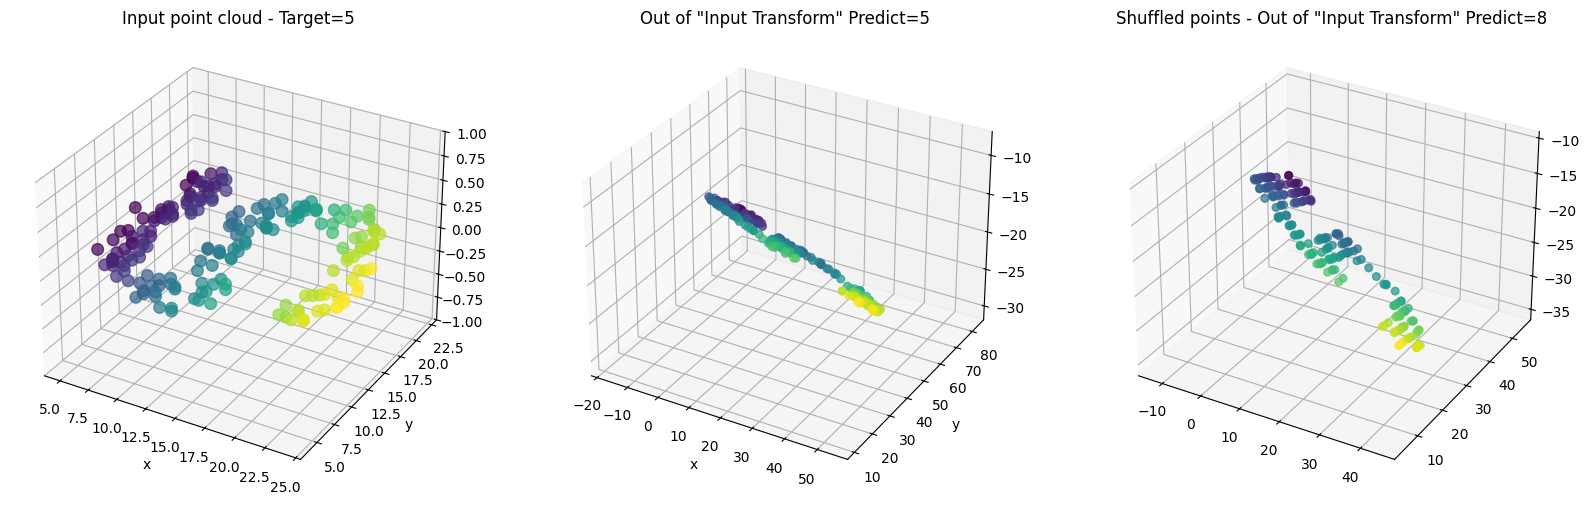

Sample: 429


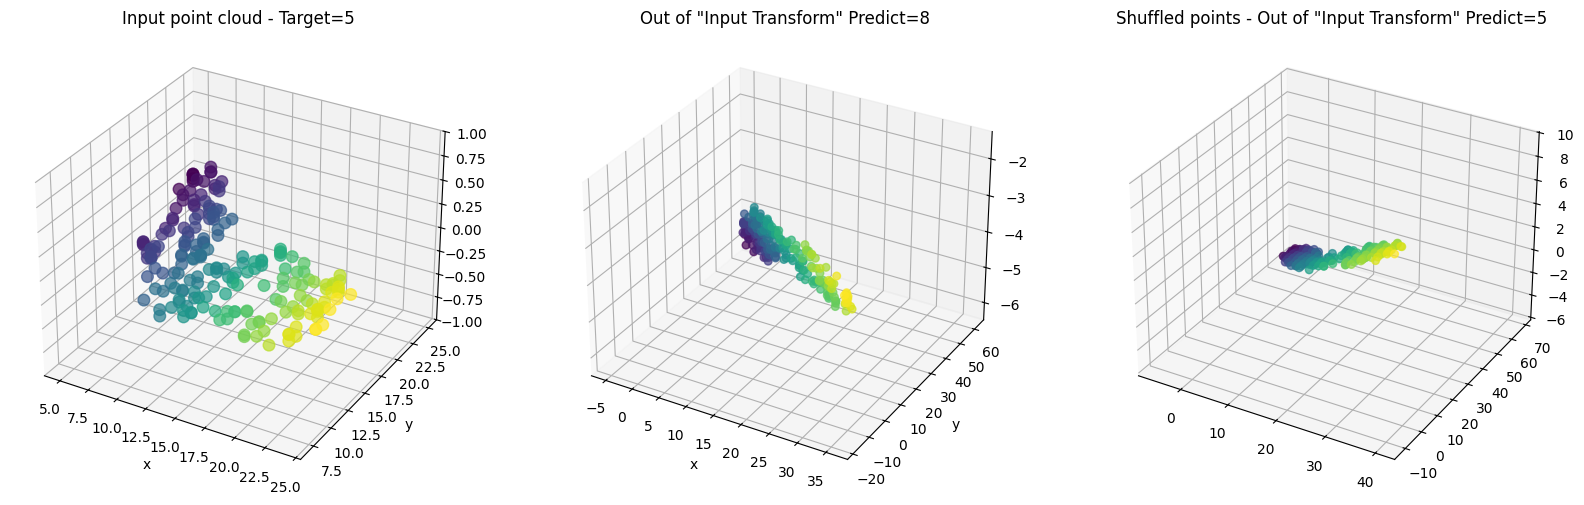

Sample: 6567


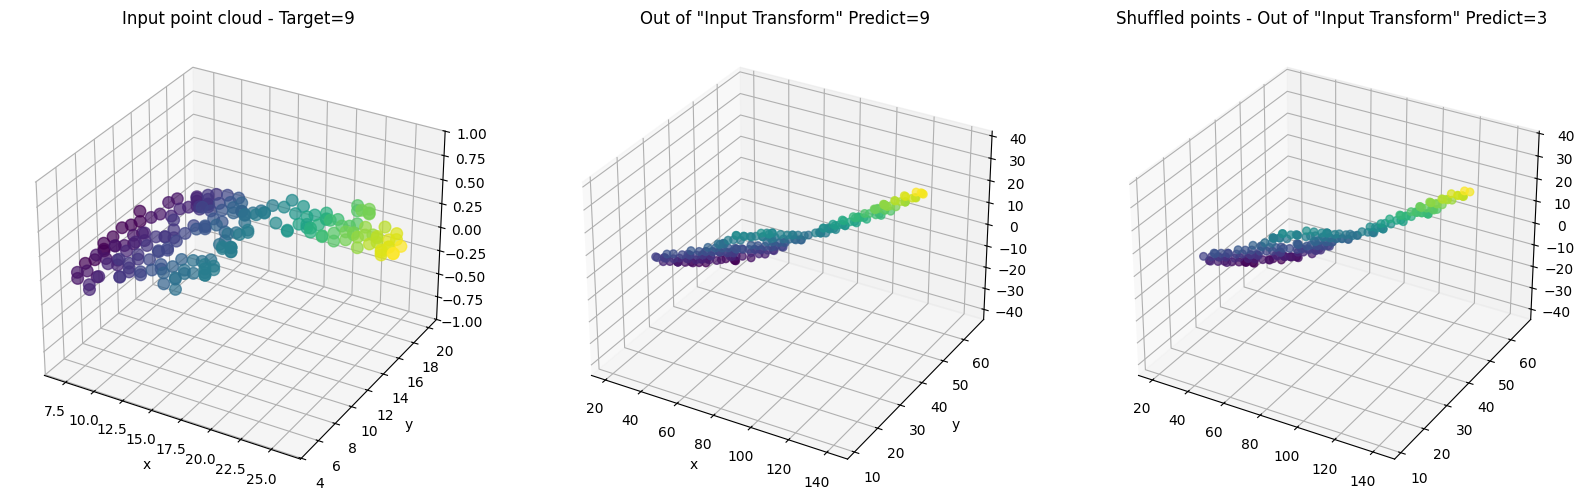

In [ ]:
# select sample from test dataset
for i in range(len(res)):
    SAMPLE=res[i]

    fig = plt.figure(figsize=[20,6])
    input_points = test_dataset[SAMPLE][0]
    label = test_dataset[SAMPLE][1]
    print(f'Sample: {SAMPLE}')

    # plot input sample
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    pc = test_dataset[SAMPLE][0].numpy()
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=70, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    ax.title.set_text(f'Input point cloud - Target={label}')

    # plot transformation
    ax = fig.add_subplot(1, 3, 2, projection='3d')

    preds = results[SAMPLE]
    points = tnet_out_list[SAMPLE]

    sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=30, marker='o',
                    cmap="viridis", alpha=0.7)
    ax.title.set_text('Out of "Input Transform" Predict=%s' % preds)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # plot transformation with shuffled points
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    preds = results_shuffle[SAMPLE]
    points = tnet_out_shuffle_list[SAMPLE]
    sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=30, marker='o',
                    cmap="viridis", alpha=0.7)
    ax.title.set_text('Shuffled points - Out of "Input Transform" Predict=%s' % preds)
    plt.show()


In [ ]:
points =tnet_out_shuffle_list[1][0,:,:].transpose()
plot_animated_3d(points, xaxis_range=[-100,100])

### Visualizing PointNet Critical points

PointNet  learns to summarize an input point cloud by a sparse set of key points, which roughly corresponds to the skeleton of objects according to visualization. The **critical point sets are those that contributed to the max pooled feature**.

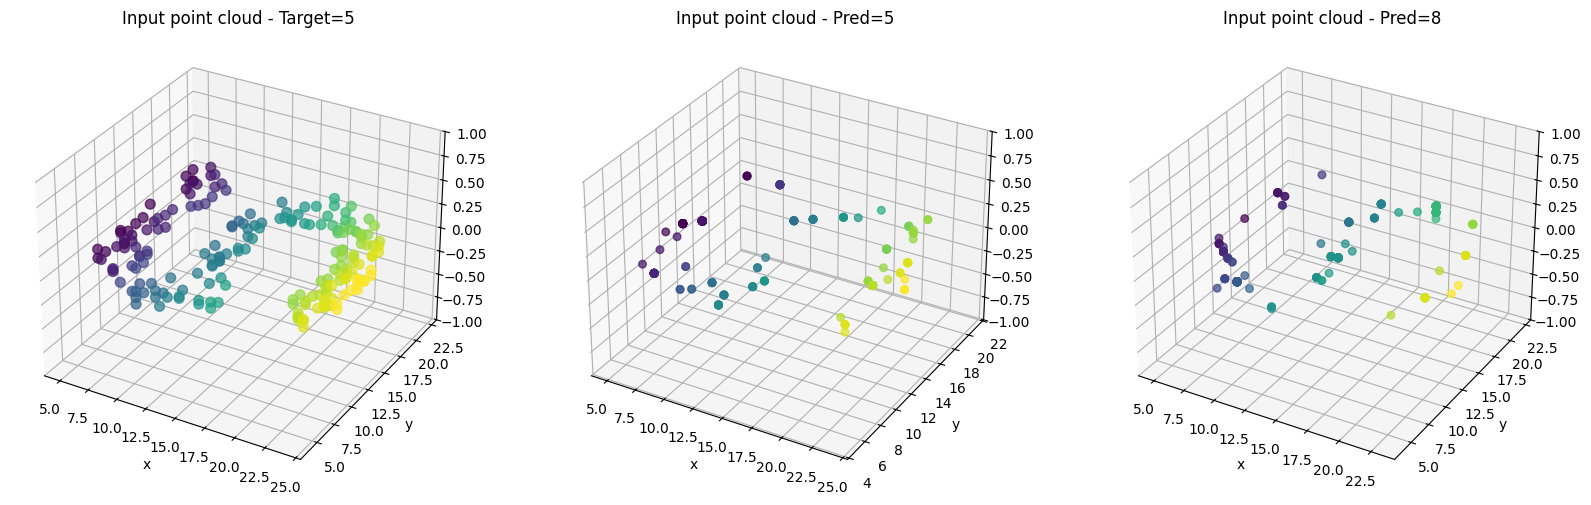

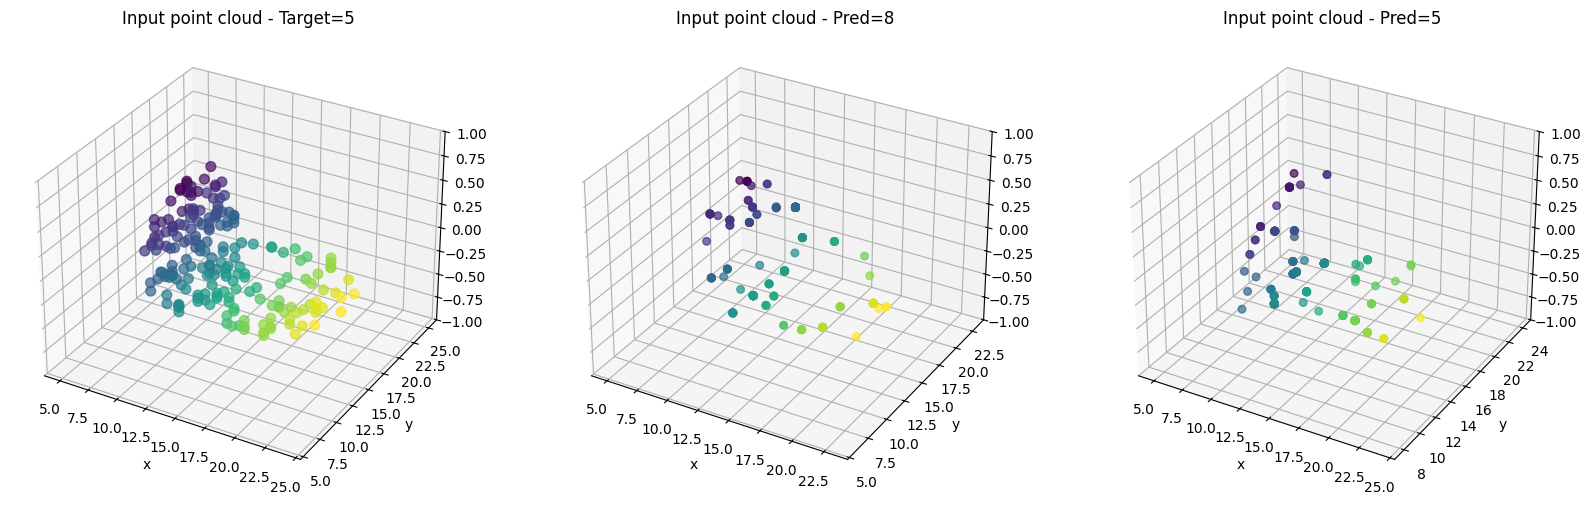

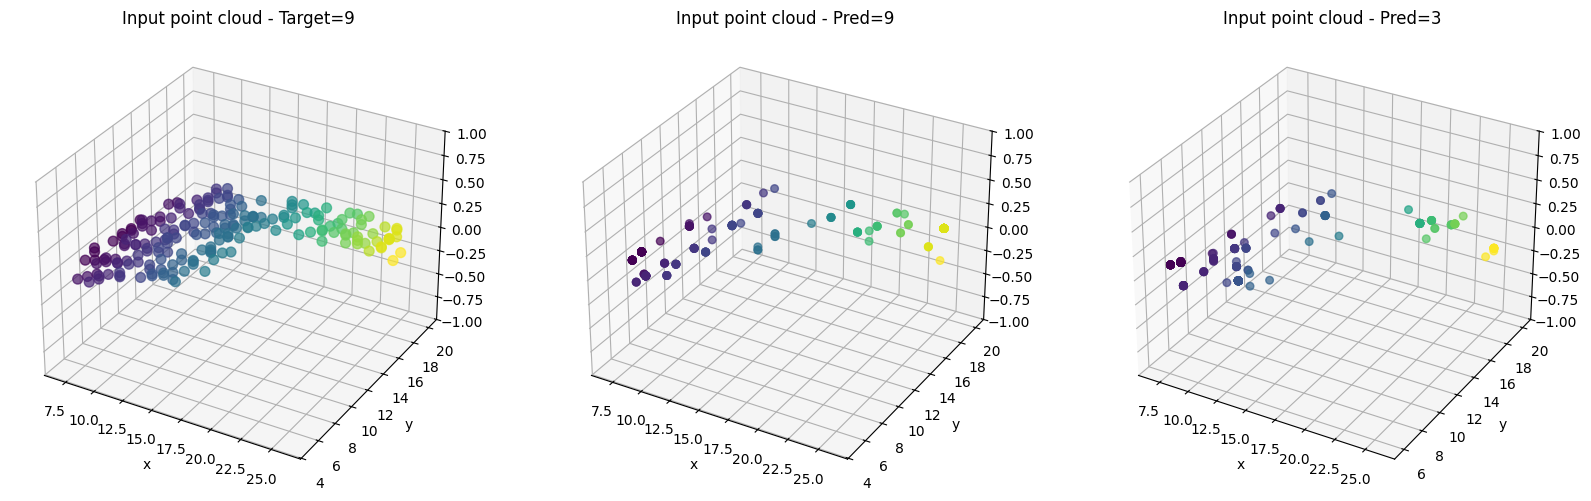

In [ ]:
# select sample from test dataset
for k in range(len(res)):
    SAMPLE = res[k]

    pc = test_dataset[SAMPLE][0].numpy()
    fig = plt.figure(figsize=[20,6])
    input_points = test_dataset[SAMPLE][0]
    label = test_dataset[SAMPLE][1]

    # plot input sample
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=50, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    ax.title.set_text(f'Input point cloud - Target={label}')

    # plot critical points
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    pc1 = pc[list(set(list_ix_o[0].reshape(256))), :]
    sc = ax.scatter(pc1[:,0], pc1[:,1], pc1[:,2], c=pc1[:,0] ,s=30, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    preds = results[SAMPLE]
    ax.title.set_text(f'Input point cloud - Pred={preds}')

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    pc = test_dataset[SAMPLE][0].numpy()
    pc = pc[list(set(list_ix_shuffle[0].reshape(256))), :]
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=30, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    preds = results_shuffle[SAMPLE]
    ax.title.set_text(f'Input point cloud - Pred={preds}')

# Take aways

We have played with **PointNet**, a neural network that **directly consumes point clouds** which is the best representation of data when dealing with 3D objects and scenes. We have seen:
- PointNet **requires a fixed number of points** per point cloud that we solved with sampling and genereting snythetic points.
- **TNet** aligns both input points and point features by predicting a **transformation matrix** directly applied to the data.
- The **max pooling layer as a symmetric function to aggregate information** from all the points, can be used at the same time for explainability of results.
